# STATS 542: Homework 8

<h4><center> Diego Kleiman (diegoek2) </center></h4>
<h4><center> Due: Tuesday 11:59 PM CT, Mar 30th </center></h4>

## About HW8

We practice two main tools: PCA and $k$-means. For $k$-means, you need to code your own algorithm. For PCA, understand how to perform prediction using the rotation matrix and effectively reduce the dimension. 

## Question 1 [50 Points] Implement the K-Means Algorithm

Write your own code of k-means. The algorithm essentially performs the following:

  * Initialize cluster means or cluster membership
  * Iterate between the updates of cluster means and membership
  * Output the results when they do not change anymore
  
You should consider the following while writing the algorithm:

  * Avoiding over-use of for-loop such that your code can be applied to data with larger size (in question 2)
  * [10 points] You should further consider multiple starting values and compare the within-cluster distances to pick the best
  * [15 points] Compare your results with a built-in $k$ means algorithm, e.g., `kmeans()`, on the `iris` data. Make sure that you understand the iris data. For both your code and the built-in function, use $k=3$. Try 1 and 20 random starts and compare the results with different seeds. Do you observe any difference? What is the cause of the difference?

In [1]:
def k_means(X, y, n_centroids=3, n_seeds=10,  max_iter=300):
    '''
    k-means clustering implementation.
    
    Arguments
    -------------
    X: np.ndarray of shape (n_samples, n_features). Data to cluster.
    y: np.ndarray of shape (n_samples,). Targets labels for X.
    n_seeds: int (default 10). The function will fit `n_seeds` different models starting from different random datapoints.
            The best model (i.e., model with lowest within-cluster variance) is selected and returned.
    max_iter: int (default 300). Limit of times to iterate if cluster assignments do not stabilize.
    
    Returns
    -------------
    results: dictionary containing the following keys:
        centroids: np.ndarray of shape (n_centroids, n_features). Centroids used by best model.
        predictions: np.ndarray of shape (n_samples,). Predicted targets according to best model.
        errors: np.ndarray of shape (n_seeds,). Classification error for all models.
        wcss: np.ndarray of shape (n_seeds,). Within-cluster sum of squares for all models.
        model: callable. Best model obtained (i.e., model with lowest within-cluster variance).
        seeds: np.ndarray of shape (n_seeds,). Numpy seeds used.
    '''

    assert(X.shape[0] == y.shape[0])
    n_samples = X.shape[0]
    n_features = X.shape[1]
    
    # Intialize arrays
    wcss_all = np.empty((n_seeds)) # Within-cluster sum of squares (error metric that will be used to compare different models)
    centroids_all = np.empty((n_seeds, n_centroids, n_features))
    predictions_all = np.empty((n_seeds, n_samples))
    errors_all = np.empty((n_seeds))
    mapping_labels_all = []
    
    np.random.seed() # Make sure global seed is not set
    seeds = np.random.randint(2**32, size=n_seeds)

    # Global loop for testing different seeds
    for i, seed in enumerate(seeds):
        np.random.seed(seed)
        centroids = select_initial_centroids(X, n_centroids)
        centroids_new, wcss, predictions = k_means_fit_helper(X, y, centroids, max_iter=max_iter)
        centroids_all[i, :, :] = centroids_new
        wcss_all[i] = wcss
        predictions_all[i, :] = predictions
    
    # Compute classification errors
    for i, predictions in enumerate(predictions_all):
        errors_all[i], mapping_labels = classification_error(y, predictions, n_centroids)
        mapping_labels_all.append(mapping_labels)
    
    # Select best model (based on wcss)
    best = wcss_all.argmin()
    centroids_best = centroids_all[best]
    predictions_best = predictions_all[best]
    mapping_labels_best = mapping_labels_all[best]
    model = k_means_get_model(centroids_best, mapping_labels_best)
    
    results = {
        'centroids': centroids_best,
        'predictions': predictions_best.astype(int),
        'errors': errors_all, # User can see best model error with errors[wcss.argmin()]
        'wcss': wcss_all, # User can see best model wcss with wcss[wcss.argmin()]
        'model': model,
        'seeds': seeds, # User can see best model seed with seeds[wcss.argmin()]
             }
    
    np.random.seed() # Make sure global seed is not set when exiting function

    return results

def select_initial_centroids(X, n_centroids):
    '''
    Select initial centroids using k-means++ to avoid initialization traps.
    '''
    n_samples = X.shape[0]
    n_features = X.shape[1]
    
    X_copy = X.copy()
    centroids = []
    first = np.random.choice(n_samples)
    centroids.append(X_copy[first])
    X_copy = np.delete(X_copy, first, 0)
    for i in range(n_centroids-1):
        distances = np.sqrt(((X_copy - np.asarray(centroids)[:, None])**2).sum(axis=2))
        min_distances = distances.min(axis=0)
        probability = min_distances**2/(min_distances**2).sum()
        new_centroid = np.random.choice(n_samples - len(centroids), p=probability)
        centroids.append(X_copy[new_centroid])
        X_copy = np.delete(X_copy, new_centroid, 0)
    
    return np.asarray(centroids)
    
def k_means_fit_helper(X, y, centroids, max_iter=300):
    '''
    Fit a k-means model with given starting centroids.
    '''
    prev_assignments = None
    for _ in range(max_iter):
        distances = np.sqrt(((X - centroids[:, None])**2).sum(axis=2)) # Pairwise distances between points and centroids
        assignments = distances.argmin(axis=0).astype(int) # Index of closest centroid for each point

        # The formula below iterates over all clusters: it selects all the points that belong to the cluster 
        # and updates the centroid location by averaging the points
        centroids = np.asarray([X[np.where(assignments==cluster)].mean(axis=0) for cluster in range(centroids.shape[0])])
        
        # If all cluster assignments are the same as before, terminate and return because the centroids did not move
        if (prev_assignments is not None) and (np.all(assignments==prev_assignments)):
            break
        prev_assignments = assignments
    
    predictions = assignments
    wcss = np.sum(distances.min(axis=0)**2)
    
    return centroids, wcss, predictions

def classification_error(target, predicted, n_centroids, manual_mapping=None):
    assert(target.shape[0] == predicted.shape[0])
    n_samples = target.shape[0]
    
    # Mapping from predicted to target labels
    # This is based on "majority polling" (i.e., if the majority of the points that are labelled 
    # 1, according to ground truth, are predicted to be in cluster #2, then predicted label 2 becomes 
    # label 1)
    
    if manual_mapping is None:
        most_likely_labels = []
        used_labels = []

        for i in range(n_centroids):
            indices = np.where(target==i)
            predicted_labels = predicted[indices]
            unique, count = np.unique(predicted_labels, return_counts=True)
            possible_labels = unique[np.argsort(count)[::-1]]    

            # This loop is to guarantee that there will be no "many-to-one" mapping
            for pl in possible_labels:
                if pl in used_labels:
                    continue
                else:
                    final_label = pl
                    used_labels.append(pl)
                    break
            most_likely_labels.append((final_label, i))
    else:
        most_likely_labels = manual_mapping
    
    # Re-number predicted labels to match target labels
    temp = predicted.copy()
    for i, j in most_likely_labels:
        temp[np.where(predicted==i)] = j
    predicted[:] = temp
    
    return np.count_nonzero(np.where(target!=predicted))/n_samples, most_likely_labels

def k_means_get_model(centroids, mapping_labels):
    '''
    Returns callable model to make further predictions (classification) on test data.
    '''
    
    def model(X_test, y=None):
        distances = np.sqrt(((X_test - centroids[:, None])**2).sum(axis=2))
        wcss = np.sum(distances.min(axis=0)**2)
        predictions = distances.argmin(axis=0)
        error = classification_error(y, predictions, centroids.shape[0], manual_mapping=mapping_labels) if (y is not None) else None
        return predictions, wcss, error
    
    return model

### Load data

In [2]:
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans

iris = datasets.load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']

### Trial with one random seed 

In [3]:
my_kmeans_results = k_means(X, y, n_centroids=3, n_seeds=1)
sklearn_results = KMeans(n_clusters=3, n_init=1).fit(X, y)

In [4]:
print("My predictions:")
print(my_kmeans_results['predictions'])

My predictions:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
 2 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 2 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1]


In [5]:
print("sklearn predictions:")
print(sklearn_results.labels_)

sklearn predictions:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 2 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]


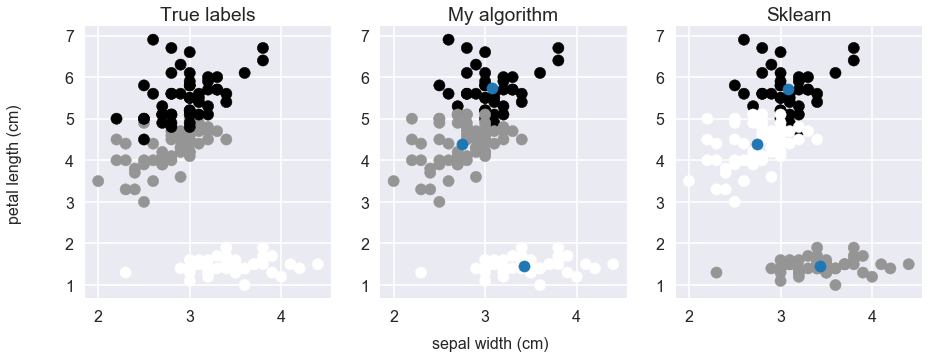

In [6]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-poster')
plt.style.use('seaborn-darkgrid')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
dim1 = X[:, 1]
dim2 = X[:, 2]
ax1.scatter(dim1, dim2, c=y)
ax2.scatter(dim1, dim2, c=my_kmeans_results['predictions'])
ax2.scatter(my_kmeans_results['centroids'][:, 1], my_kmeans_results['centroids'][:, 2])
ax3.scatter(dim1, dim2, c=sklearn_results.labels_)
ax3.scatter(sklearn_results.cluster_centers_[:, 1], sklearn_results.cluster_centers_[:, 2])
fig.text(0.5, 0.0, iris['feature_names'][1], ha='center', va='center', fontsize=16)
fig.text(0.06, 0.5, iris['feature_names'][2], ha='center', va='center', rotation='vertical', fontsize=16)
ax1.title.set_text("True labels")
ax2.title.set_text("My algorithm")
ax3.title.set_text("Sklearn")
plt.show()
plt.close()

Cluster centers are marked in blue. Note that the colors are not necessarily expected to correspond to those of the true lables.  

In [7]:
print("Within-cluster sums of squares:", my_kmeans_results['wcss'].min())
print("Classification error:", my_kmeans_results['errors'][my_kmeans_results['wcss'].argmin()])
print("Random seed used:", my_kmeans_results['seeds'][my_kmeans_results['wcss'].argmin()])

Within-cluster sums of squares: 78.85144142614601
Classification error: 0.10666666666666667
Random seed used: 1427812006


### Trial with twenty random seeds

In [8]:
my_kmeans_results = k_means(X, y, n_centroids=3, n_seeds=20)
sklearn_results = KMeans(n_clusters=3, n_init=20).fit(X, y)

In [9]:
print("My predictions:")
print(my_kmeans_results['predictions'])

My predictions:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
 2 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 2 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1]


In [10]:
print("sklearn predictions:")
print(sklearn_results.labels_)

sklearn predictions:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 0 0 0 2 0 0 0 0
 0 0 2 2 0 0 0 0 2 0 2 0 2 0 0 2 2 0 0 0 0 0 2 0 0 0 0 2 0 0 0 2 0 0 0 2 0
 0 2]


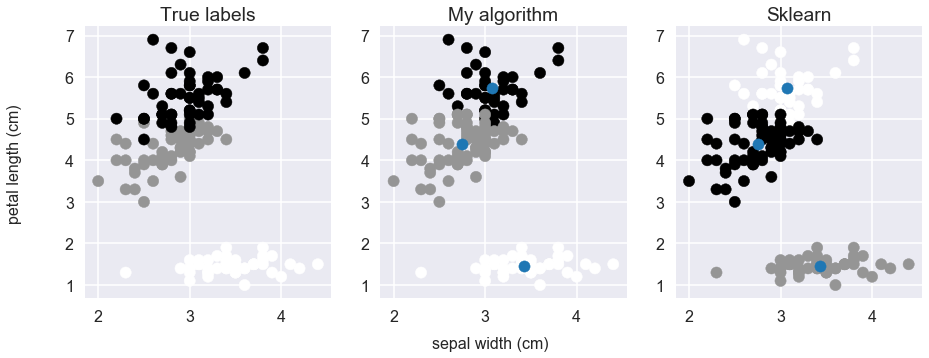

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
dim1 = X[:, 1]
dim2 = X[:, 2]
ax1.scatter(dim1, dim2, c=y)
ax2.scatter(dim1, dim2, c=my_kmeans_results['predictions'])
ax2.scatter(my_kmeans_results['centroids'][:, 1], my_kmeans_results['centroids'][:, 2])
ax3.scatter(dim1, dim2, c=sklearn_results.labels_)
ax3.scatter(sklearn_results.cluster_centers_[:, 1], sklearn_results.cluster_centers_[:, 2])
fig.text(0.5, 0.0, iris['feature_names'][1], ha='center', va='center', fontsize=16)
fig.text(0.06, 0.5, iris['feature_names'][2], ha='center', va='center', rotation='vertical', fontsize=16)
ax1.title.set_text("True labels")
ax2.title.set_text("My algorithm")
ax3.title.set_text("Sklearn")
plt.show()
plt.close()

Cluster centers are marked in blue. Note that the colors are not necessarily expected to correspond to those of the true lables.  

In [12]:
print("Within-cluster sums of squares (best):", my_kmeans_results['wcss'].min())
print("Classification error (best model):", my_kmeans_results['errors'][my_kmeans_results['wcss'].argmin()])
print("Random seed used (best model):", my_kmeans_results['seeds'][my_kmeans_results['wcss'].argmin()])

Within-cluster sums of squares (best): 78.85144142614601
Classification error (best model): 0.10666666666666667
Random seed used (best model): 3538502485


**Answer:**

I did not observe any significant difference between the two trials. I arrived at this conclusion because the classification error, within-cluster sum of squares, and the general aspect of the plot are the same. However, if I ran the single-seed trial many times, it is possible that I would encounter a seed that returns a bad local minimum of the optimization function. But since I implemented the k-means++ algorithm to prevent initialization traps, the chances of this happening are reduced since this method is a fairly robust initialization strategy.

## Question 2 [50 Points] Clustering, Classification and Dimension Reduction

Although clustering is an unsupervised algorithm, it may sometimes reveal the underlying true (unobserved) label associated with each observation. For this question, apply your K means clustering algorithm on the handwritten digit data (`zip.train` from the `ElemStatLearn` package). We only use digits 1, 4 and 8. 

  * Given your clustering results, can you propose a method to assign class labels to each of your clusters?
  * With your assigned cluster labels, how to predict labels on the `zip.test` data?
  * What is the classification error based on your model? A classification error is defined as $\frac{1}{n}\sum_i 1(y_i \neq \hat y_i)$.

Dimensionality often causes problems in a lot of machine learning algorithms. PCA is an effective way to reduce the dimension without sacrificing the clustering/classification performances. Repeat your analysis by

  * Process your data using PCA. Plot the data on a two-dimensional plot using the first two PC's. Mark the data points with different colors to represent their digits. 
  * Based on the first two PCs, redo the k-means algorithm. Again, assign each cluster a label of the digit, and predict the label on the testing data. You need to do this prediction properly, meaning that your observed testing data is still the full data matrix, and you should utilize the information of PCA from the training data to construct new features of the testing data. 
  * Compare your PCA results with the results obtained by using the entire dataset. How much classification accuracy is sacrificed by using just two dimensions?
  * Comment on the potential strength and drawback of this dimension reduction approach compared with the raw data approach.

In [13]:
import os
os.environ['R_HOME'] = "/Users/diegoeduardo/opt/anaconda3/envs/R/lib/R"
import rpy2.robjects as robjects

# Load datasets
robjects.r['load']('zip.train.RData')
robjects.r['load']('zip.test.RData')

# Retrieve datsets as Python objects
zip_train = robjects.r['zip.train']
zip_test = robjects.r['zip.test']

# Convert to numpy.ndarray
zip_train = np.array(zip_train)
zip_test = np.array(zip_test)

ones = (zip_train[:, 0] == 1)
fours = (zip_train[:, 0] == 4)
eights = (zip_train[:, 0] == 8)
selection_mask = np.logical_or(np.logical_or(ones, fours), eights)
one_four_eight_train = zip_train[selection_mask]

ones = (zip_test[:, 0] == 1)
fours = (zip_test[:, 0] == 4)
eights = (zip_test[:, 0] == 8)
selection_mask = np.logical_or(np.logical_or(ones, fours), eights)
one_four_eight_test = zip_test[selection_mask]

X_train = one_four_eight_train[:, 1:]
y_train = one_four_eight_train[:, 0]
# Labels are renumbered from 1, 4, 8 to 0, 1, 2
y_train[np.where(y_train==1)] = 0
y_train[np.where(y_train==4)] = 1
y_train[np.where(y_train==8)] = 2

X_test = one_four_eight_test[:, 1:]
y_test = one_four_eight_test[:, 0]
# Labels are renumbered from 1, 4, 8 to 0, 1, 2 
y_test[np.where(y_test==1)] = 0
y_test[np.where(y_test==4)] = 1
y_test[np.where(y_test==8)] = 2

### Trial with full dimensionality 

In [14]:
my_kmeans_results_zip = k_means(X_train, y_train, n_centroids=3)

In [15]:
print("Train results")
print("Within-cluster sums of squares (best):", my_kmeans_results_zip['wcss'].min())
print("Classification error (best model):", my_kmeans_results_zip['errors'][my_kmeans_results_zip['wcss'].argmin()])
print("Random seed used (best model):", my_kmeans_results_zip['seeds'][my_kmeans_results_zip['wcss'].argmin()])

Train results
Within-cluster sums of squares (best): 124808.58081291642
Classification error (best model): 0.042746703046839474
Random seed used (best model): 543910319


In [16]:
test_results = my_kmeans_results_zip['model'](X_test, y=y_test)

In [17]:
print("Test results")
print("Within-cluster sums of squares (test):", test_results[1])
print("Classification error (test):", test_results[2][0])

Test results
Within-cluster sums of squares (test): 41842.438959190215
Classification error (test): 0.05555555555555555


**Questions from this section**

  * Given your clustering results, can you propose a method to assign class labels to each of your clusters?
  * With your assigned cluster labels, how to predict labels on the `zip.test` data?
  * What is the classification error based on your model? A classification error is defined as $\frac{1}{n}\sum_i 1(y_i \neq \hat y_i)$.

**Answers:**
    
* The method I proposed to assign class labels to my clusters is implemented in the function `classification_error` from Q1. I have not done thorough testing of this method and found no proof that it is optimal, so I do not expect this technique to always return the best mapping between clusters and labels. Probably using a different metric, such as V-score (the harmonic mean of completeness and homogeneity) would be better. Regardless, this is how my method it works: 
1. I count how many datapoints with true label $i$ fall in each predicted cluster. 
2. If the majority of datapoints with true label $i$ are in cluster $c$, I assign the label $i$ to cluster $c$ ($c \rightarrow i$). 
3. If the cluster $c$ was already assigned another label $j$ (imagine labels $i$ and $j$ have the majority of their members in cluster $c$, for example), then I find the second best cluster $d$, such that it contains the second highest number of elements labelled $i$. In this case, I assign label $i$ to cluster $d$. This step can repeat itself until a suitable label is found.

Note that when I am using test data, I need to pass the mapping for $clusters \rightarrow labels$ obtained with the training data.



* To predict the test labels, I use the $clusters \rightarrow labels$ mapping that I got from the training data (based on the method I described above).
* I have printed the classification errors for training and testing above. The training error is $4.27\%$ while the test error is $~5.56\%$.

### Trial with two principal components

In [18]:
from sklearn.decomposition import PCA
PCA_transformer = PCA(n_components=2).fit(X_train)

In [19]:
X_train_reduced = PCA_transformer.transform(X_train)
X_test_reduced = PCA_transformer.transform(X_test)

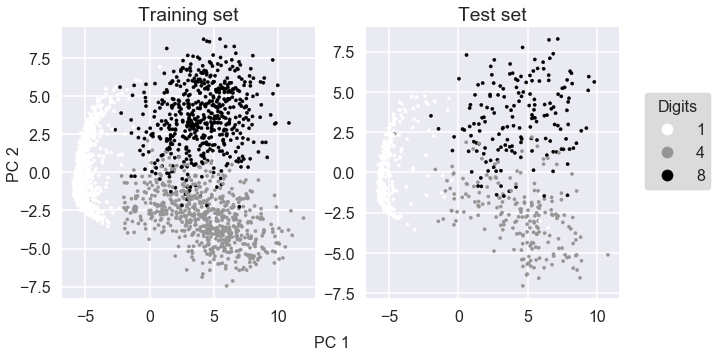

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

dim1_train = X_train_reduced[:, 0]
dim2_train = X_train_reduced[:, 1]
sc1 = ax1.scatter(dim1_train, dim2_train, c=y_train, s=10, label=y_train)

legend1 = ax1.legend(*sc1.legend_elements(), 
                     title="Digits", 
                     facecolor='lightgray', 
                     frameon=True, 
                     loc=(2.3,.4), 
                     fontsize=16)
legend1.get_texts()[0].set_text('1')
legend1.get_texts()[1].set_text('4')
legend1.get_texts()[2].set_text('8')
legend1.get_title().set_fontsize(16)

dim1_test = X_test_reduced[:, 0]
dim2_test = X_test_reduced[:, 1]
ax2.scatter(dim1_test, dim2_test, c=y_test, s=10, label=y_test)

fig.text(0.5, 0.0, "PC 1", ha='center', va='center', fontsize=16)
fig.text(0.06, 0.5, "PC 2", ha='center', va='center', rotation='vertical', fontsize=16)
ax1.title.set_text("Training set")
ax2.title.set_text("Test set")

plt.show()
plt.close()

In [21]:
my_kmeans_results_zip_reduced = k_means(X_train_reduced, y_train, n_centroids=3)

In [22]:
print("Train results")
print("Within-cluster sums of squares (best):", my_kmeans_results_zip_reduced['wcss'].min())
print("Classification error (best model):", my_kmeans_results_zip_reduced['errors'][my_kmeans_results_zip_reduced['wcss'].argmin()])
print("Random seed used (best model):", my_kmeans_results_zip_reduced['seeds'][my_kmeans_results_zip_reduced['wcss'].argmin()])

Train results
Within-cluster sums of squares (best): 15235.613943001461
Classification error (best model): 0.05547976352887676
Random seed used (best model): 3134759520


In [23]:
test_results_reduced =  my_kmeans_results_zip_reduced['model'](X_test_reduced, y=y_test)

In [24]:
print("Test results")
print("Within-cluster sums of squares (test):", test_results_reduced[1])
print("Classification error (test):", test_results_reduced[2][0])

Test results
Within-cluster sums of squares (test): 4706.490605382254
Classification error (test): 0.08253968253968254


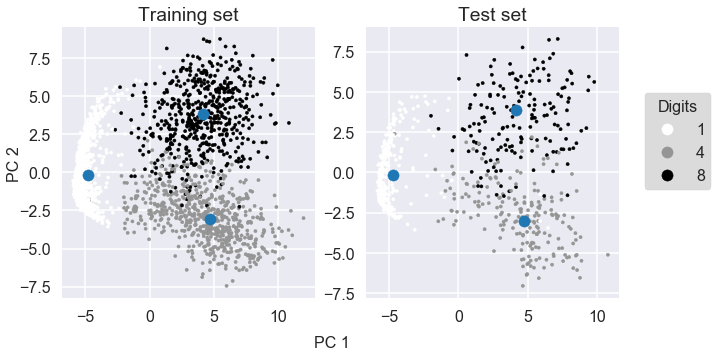

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

dim1_train = X_train_reduced[:, 0]
dim2_train = X_train_reduced[:, 1]
sc1 = ax1.scatter(dim1_train, dim2_train, c=y_train, s=10, label=y_train)

ax1.scatter(my_kmeans_results_zip_reduced['centroids'][:, 0], my_kmeans_results_zip_reduced['centroids'][:, 1])

legend1 = ax1.legend(*sc1.legend_elements(), 
                     title="Digits", 
                     facecolor='lightgray', 
                     frameon=True, 
                     loc=(2.3,.4), 
                     fontsize=16)
legend1.get_texts()[0].set_text('1')
legend1.get_texts()[1].set_text('4')
legend1.get_texts()[2].set_text('8')
legend1.get_title().set_fontsize(16)

dim1_test = X_test_reduced[:, 0]
dim2_test = X_test_reduced[:, 1]
ax2.scatter(dim1_test, dim2_test, c=y_test, s=10, label=y_test)
ax2.scatter(my_kmeans_results_zip_reduced['centroids'][:, 0], my_kmeans_results_zip_reduced['centroids'][:, 1])

fig.text(0.5, 0.0, "PC 1", ha='center', va='center', fontsize=16)
fig.text(0.06, 0.5, "PC 2", ha='center', va='center', rotation='vertical', fontsize=16)
ax1.title.set_text("Training set")
ax2.title.set_text("Test set")

plt.show()
plt.close()

Note: this is the exact same plot as before but with cluster centers marked in blue.

### Questions from this section

* Process your data using PCA. Plot the data on a two-dimensional plot using the first two PC's. Mark the data points with different colors to represent their digits. 
* Based on the first two PCs, redo the k-means algorithm. Again, assign each cluster a label of the digit, and predict the label on the testing data. You need to do this prediction properly, meaning that your observed testing data is still the full data matrix, and you should utilize the information of PCA from the training data to construct new features of the testing data. 
* Compare your PCA results with the results obtained by using the entire dataset. How much classification accuracy is sacrificed by using just two dimensions?
* Comment on the potential strength and drawback of this dimension reduction approach compared with the raw data approach.

**Answers:**

* See code and plots above.
* See code above.
* See results above. The classification error from the training data with full dimensionality was $4.27\%$ while it was $5.55\%$ using the two principal components. For the testing data, the classification error was $5.56\%$ with raw data versus $8.25\%$ with PCA. We can conclude that there is an evident (albeit small) loss of classification performance when using only a low dimensional decomposition of the data. This is more evident in the testing set, meaning that the model trained with the two PCs could have a higher irreducible error (it is unlikely that it overfits because it is a simpler model than the full dimensionality one).
* The dimensionality reduction approach is useful because training the model and computing predictions on lower-dimensional data takes less time and space. Of course, finding the principal component decomposition of our training data has its own computational demands. However, this step is done only once, so its cost is "amortized" when we train the model and make further predictions on test data or new incoming data. The drawback of using PCA is obviously that we might lose accuracy if we are unable to perfectly separate the datapoints in the new lower-dimensional space, as it happened in our case (see plots above).